# Can we observe H$\alpha$ in Spring 2023?

At McDonald Observatory 2.7 m

In [1]:
import astroplan

In [2]:
from astropy.coordinates import SkyCoord
from astroplan import FixedTarget

coordinates = SkyCoord.from_name('HAT-P-67')
targ = FixedTarget(name='HAT-P-67', coord=coordinates)

In [3]:
targ

<FixedTarget "HAT-P-67" at SkyCoord (ICRS): (ra, dec) in deg (256.61067007, 44.77696346)>

In [4]:
from astroplan import Observer
observer = Observer.at_site('McDonald')

In [5]:
t0 = 2455961.384670

In [6]:
from astropy.time import Time
import astropy.units as u
from astroplan import EclipsingSystem

primary_eclipse_time = Time(t0, format='jd')
orbital_period = 4.810102500 * u.day
eclipse_duration = 6.9888 * u.hour

hatp = EclipsingSystem(primary_eclipse_time=primary_eclipse_time,
                           orbital_period=orbital_period, duration=eclipse_duration,
                           name='HAT-P-67 b')


In [7]:
hatp

In [8]:
observing_time = Time('2023-02-17 00:00')
midtransit_times = hatp.next_primary_eclipse_time(observing_time, n_eclipses=20)

In [9]:
from astroplan import (PrimaryEclipseConstraint, is_event_observable,
                       AtNightConstraint, AltitudeConstraint, PhaseConstraint)
import datetime as dt

In [10]:
constraints = [AtNightConstraint.twilight_civil(),AltitudeConstraint(min=30*u.deg)]

In [11]:
mask = is_event_observable(constraints, observer, targ, times=midtransit_times)

In [12]:
mask[0]

array([False,  True, False, False, False, False,  True, False, False,
       False, False,  True,  True, False, False, False, False,  True,
        True, False])

In [13]:
midtransit_times.value[mask[0]]

array(['2023-02-26 08:53:51.528', '2023-03-22 10:06:35.808',
       '2023-04-15 11:19:20.088', '2023-04-20 06:45:52.944',
       '2023-05-14 07:58:37.224', '2023-05-19 03:25:10.080'], dtype='<U23')

## Plot phases and constraints

In [25]:
from astroplan import PeriodicEvent, MoonSeparationConstraint, AirmassConstraint
from astroplan.utils import time_grid_from_range
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [15]:
epoch = Time(t0, format='jd')

In [16]:
planetb = PeriodicEvent(epoch=epoch, period=orbital_period)

In [26]:
constraints = [AtNightConstraint.twilight_civil(),
               AirmassConstraint(max=3.2), 
              PhaseConstraint(planetb, min=0.465, max=0.533),
              PhaseConstraint(planetb, min=0.2, max=0.60)]

In [27]:
# Define range of times to observe between
start_time = Time('2023-03-30 00:00:01')
end_time = Time('2023-04-05 00:00:01')
time_resolution = 1 * u.hour

In [28]:
time_grid = time_grid_from_range([start_time, end_time],
                                 time_resolution=time_resolution)

In [29]:
observability_grid = np.zeros((len(constraints), len(time_grid)))

In [30]:
for i, constraint in enumerate(constraints):
    # Evaluate each constraint
    observability_grid[i, :] = constraint(observer, targ, times=time_grid)

In [31]:
[c.__class__.__name__ for c in constraints]

['AtNightConstraint',
 'AirmassConstraint',
 'PhaseConstraint',
 'PhaseConstraint']

In [42]:
ylabels = ['At Night', 'Observable', 'Transiting', 'High Priority']

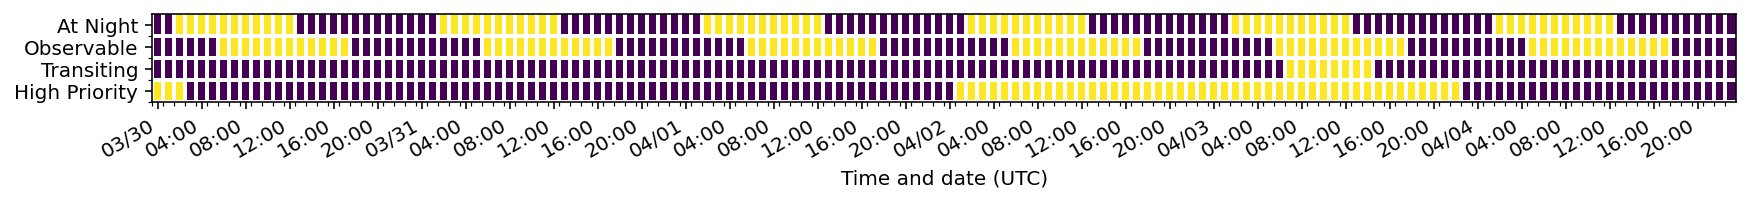

In [43]:
# Create plot showing observability of the target:

extent = [-0.5, -0.5+len(time_grid), -0.5, 3.5]

fig, ax = plt.subplots(figsize=(20, 4))
ax.imshow(observability_grid, extent=extent, aspect=2)

ax.set_yticks(range(0, len(ylabels)))
ax.set_yticklabels(ylabels[::-1])


xtick_labels_long = np.array([t.datetime.strftime("%D %H:%M") for t in time_grid])
xtick_labels_short = np.array([t.datetime.strftime("%H:%M") for t in time_grid])
xtick_labels = xtick_labels_short
mask = xtick_labels_short == '00:00'
xtick_labels[mask] = list(xtick_labels_long[mask])
xtick_subset = xtick_labels[::4]
ax.set_xticks(np.arange(0, len(xtick_labels), 4))
ax.set_xticklabels(xtick_subset)

ax.set_xticks(np.arange(extent[0], extent[1]), minor=True)
ax.set_yticks(np.arange(extent[2], extent[3]), minor=True)

ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.tick_params(axis='x', which='minor', bottom='off')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

ax.tick_params(axis='y', which='minor', left='off')
ax.set_xlabel('Time on {0} UTC'.format(time_grid[0].datetime.date()))
fig.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.1)
ax.set_xlabel('Time and date (UTC)')
plt.savefig('../../figures/HATP67_2p7m_Observability.png', dpi=300, bbox_inches='tight')

In [41]:
!open ../../figures/